<a href="https://colab.research.google.com/github/coddingyun/pytorch/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Setting

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import tensorflow as tf
torch.manual_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

data = np.load('/content/drive/MyDrive/Assignment#3_Dataset/Testset/ACRIN-FLT-Breast_006/1-062.ll.npy')
print(data.shape)

(512, 1024)


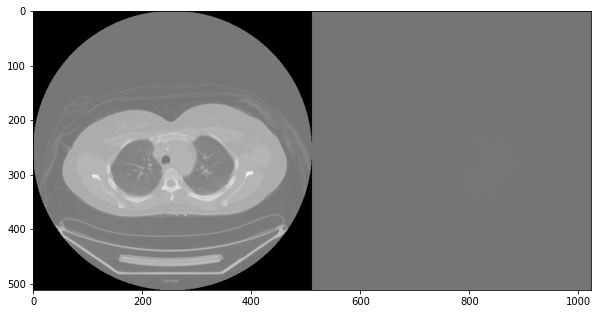

In [ ]:
import numpy as np

data = np.load('/content/drive/MyDrive/Assignment#3_Dataset/Trainset/ACRIN-FLT-Breast_002/1-073.ll.npy')

plt.figure(figsize = (10,10))
plt.imshow(data, cmap=plt.cm.gray)
plt.show()

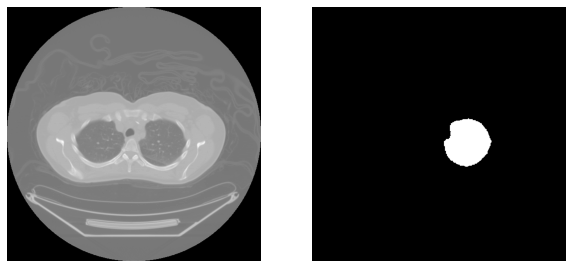

In [ ]:
data = np.load('/content/drive/MyDrive/Assignment#3_Dataset/Testset/ACRIN-FLT-Breast_006/1-073.ll.npy')
left_data=data[:, :512]
right_data=data[:,512:]
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(left_data, cmap=plt.cm.gray)
ax1.axis("off")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(right_data, cmap=plt.cm.gray)
ax2.axis("off")
plt.show()

#2. Custom dataset

세 파일에 있는 모든 사진들을 사용하기 위한 훈련 데이터셋을 위한 커스텀 데이터셋

In [ ]:
import torch
import torch.utils.data as data
import os

#커스텀 데이터셋
class tDataset(data.Dataset):
    def __init__(self, data_dir1, data_dir2, data_dir3, transform=None): # 초기상태, label과 input 주소를 불러와서 이름순 정렬
      lst_input=[]
      lst_label=[]
      for i in range(33):
        number=i+67
        string="1-0"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir1, string ))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)

      for i in range(8):
        number=i+100
        string="1-"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir1, string))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)
      
      for j in range(37):
        number=j+62
        string="1-0"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir2, string ))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)

      for j in range(5):
        number=j+100
        string="1-"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir2, string))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)
      
      for k in range(37):
        number=k+62
        string="1-0"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir3, string ))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)

      for k in range(15):
        number=k+100
        string="1-"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir3, string))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)
      self.transform = transform

      self.lst_label = lst_label
      self.lst_input = lst_input
      
    def __getitem__(self, index): #인덱스 사용할때
      labels = self.lst_label[index]
      inputs = self.lst_input[index]
      labels = labels.astype(np.float32)
      inputs = inputs.astype(np.float32)
        
# 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 
# 파이토치 인풋은 (batch, 채널, 행, 열)

      if labels.ndim == 2:  
          labels = labels[np.newaxis,:,:]
      if inputs.ndim == 2:  
          inputs = inputs[np.newaxis,:,:]

      data = {'input':inputs, 'label':labels}

      if self.transform:				
          data = self.transform(data)

      return data
    def __len__(self): #데이터셋의 개수를 알고싶을때
        return len(self.lst_label)



#3. Dice coefficient

$$Dice = \frac{{2\left| {A \cap B} \right|}}{{\left| A \right| + \left| B\right|}}$$

- 라벨링된 영역과 예측한 영역이 정확히 같다면, 1이되며 그렇지 않을 경우에는 0이 된다.

In [ ]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_pred_bin * y_true)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, n_channels, height, width)
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i,j, :, :], y_pred_bin[i,j :, :])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel

#4. Train1

###1. Unet

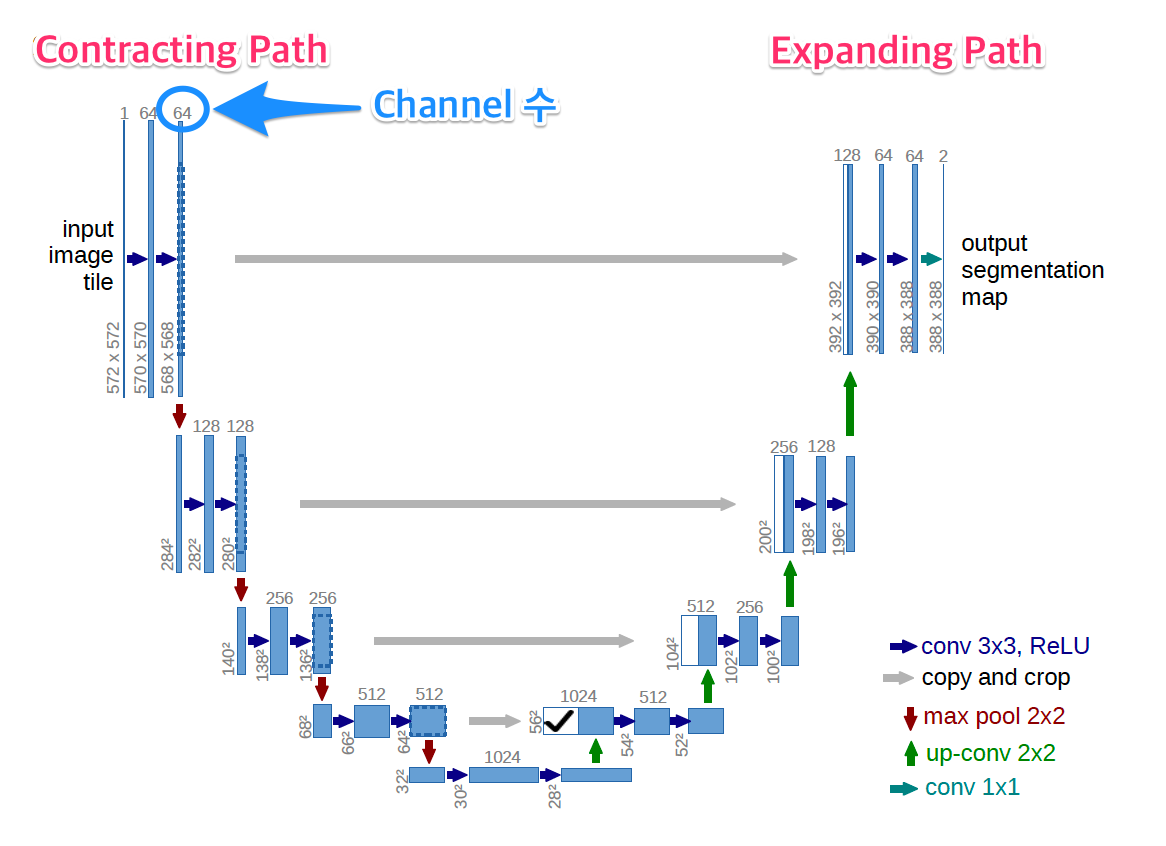

In [ ]:
# sample U-net , 가중치 초기화만 바꿈
import keras
import torch
import torch.nn.functional as F
from torch import nn


def _EncoderBlock(in_channels, out_channels, dropout=False):
      layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size=3),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
      ]
      if dropout:
          layers.append(nn.Dropout())
      layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      return layers


def _DecoderBlock(in_channels, middle_channels, out_channels):
      decode = nn.Sequential(
          nn.Conv2d(in_channels, middle_channels, kernel_size=3),
          nn.BatchNorm2d(middle_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
          nn.BatchNorm2d(middle_channels),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
      )
      return decode


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(1, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        keras.initializers.he_normal(seed=None)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear')

###2. train

135


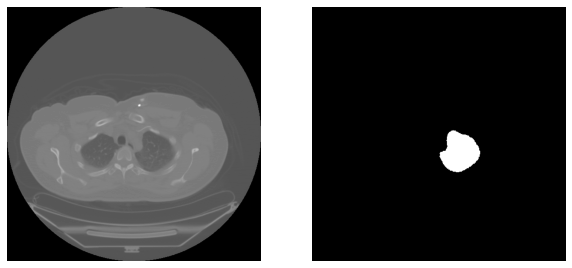

(1, 512, 512)


In [ ]:
## 하이퍼 파라미터 설정
from torchvision import transforms

lr = 1e-3
batch_size = 4
num_epoch = 10

data_dir1 = '/content/drive/MyDrive/Assignment#3_Dataset/Trainset/ACRIN-FLT-Breast_001'
data_dir2 = '/content/drive/MyDrive/Assignment#3_Dataset/Trainset/ACRIN-FLT-Breast_002'
data_dir3 = '/content/drive/MyDrive/Assignment#3_Dataset/Trainset/ACRIN-FLT-Breast_003'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#transform = transforms.Compose([transforms.Normalize(mean=0.5, std=0.5), transforms.RandomVerticalFlip(), ToTensor()]) ->이거하면 오류가 남

dataset_train = tDataset(data_dir1=data_dir1,data_dir2=data_dir2,data_dir3=data_dir3,transform=None)
print(len(dataset_train))


# 불러온 데이터셋, 배치 size줘서 DataLoader 해주기
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)

# 잘 불러와졌는지 확인
fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(dataset_train[6]['input'].reshape(512,512), cmap=plt.cm.gray)
ax1.axis("off")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(dataset_train[6]['label'].reshape(512,512), cmap=plt.cm.gray)
ax2.axis("off")
plt.show()

print(dataset_train[6]['input'].shape)

In [ ]:
# 네트워크 불러오기
net = UNet(1).to(device) # device : cpu or gpu

# loss 정의
fn_loss = nn.MSELoss().to(device)

# Optimizer 정의
optim = torch.optim.Adam(net.parameters(), lr = lr ) 

# 기타 variables 설정
num_train = len(dataset_train)
num_train_for_epoch = np.ceil(num_train/batch_size) # np.ceil : 소수점 반올림


# 네트워크 학습시키기
start_epoch = 0

for epoch in range(start_epoch+1,num_epoch +1):
    net.train()
    avg_cost=0
    total_batch=len(loader_train)
    for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
        # 배치 크기 × 채널 × 높이(height) × 너비(widht)
        output = net(inputs) 

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update
        avg_cost+=loss/total_batch
    print('Epoch:', '%04d' %(epoch), 'cost=', '{:.9f}'.format(avg_cost))
        # save loss

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Epoch: 0001 cost= 0.033495732
Epoch: 0002 cost= 0.003135968
Epoch: 0003 cost= 0.002052997
Epoch: 0004 cost= 0.001609103
Epoch: 0005 cost= 0.001332484
Epoch: 0006 cost= 0.001392349
Epoch: 0007 cost= 0.001290912
Epoch: 0008 cost= 0.001237363
Epoch: 0009 cost= 0.001067634
Epoch: 0010 cost= 0.000957783


###3. result

In [ ]:
import torch
import torch.utils.data as data
import os

#커스텀 데이터셋
class testDataset(data.Dataset):
    def __init__(self, data_dir, transform=None): # 초기상태, label과 input 주소를 불러와서 이름순 정렬
      lst_input=[]
      lst_label=[]
      for i in range(37):
        number=i+62
        string="1-0"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir, string ))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)

      for i in range(15):
        number=i+100
        string="1-"+str(number)+".ll.npy"
        img = np.load(os.path.join(data_dir, string))
        input_np = img[:, :512]
        label_np = img[:, 512:]
        lst_input.append(input_np)
        lst_label.append(label_np)
      
      self.transform = transform

      self.lst_label = lst_label
      self.lst_input = lst_input
      
    def __getitem__(self, index): #인덱스 사용할때
      labels = self.lst_label[index]
      inputs = self.lst_input[index]
      labels = labels.astype(np.float32)
      inputs = inputs.astype(np.float32)
        
# 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 
# 파이토치 인풋은 (batch, 채널, 행, 열)

      if labels.ndim == 2:  
          labels = labels[np.newaxis,:,:]
      if inputs.ndim == 2:  
          inputs = inputs[np.newaxis,:,:]

      data = {'input':inputs, 'label':labels}

      if self.transform:				
          data = self.transform(data)

      return data
    def __len__(self): #데이터셋의 개수를 알고싶을때
        return len(self.lst_label)

In [ ]:
X_test = "/content/drive/MyDrive/Assignment#3_Dataset/Testset/ACRIN-FLT-Breast_006"

dataset_test = testDataset(data_dir=X_test, transform=None)
print(len(dataset_test))


# 불러온 데이터셋, 배치 size줘서 DataLoader 해주기
loader_test = DataLoader(dataset_test, batch_size = 1, shuffle=True)

52


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


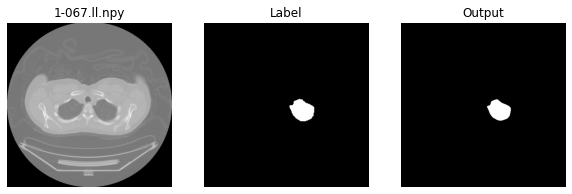

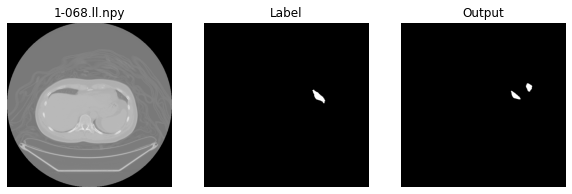

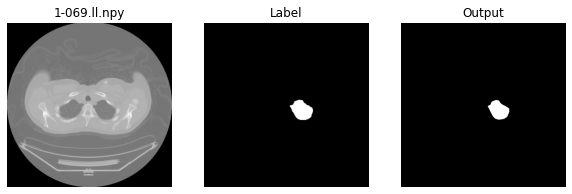

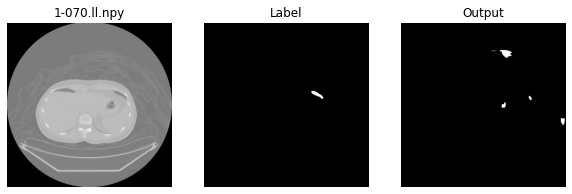

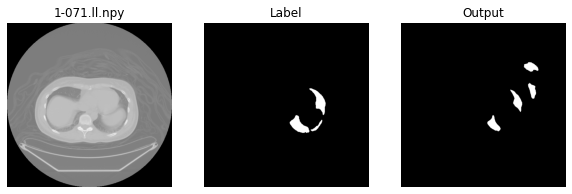

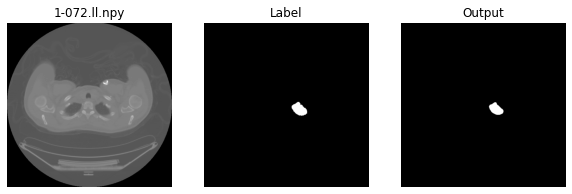

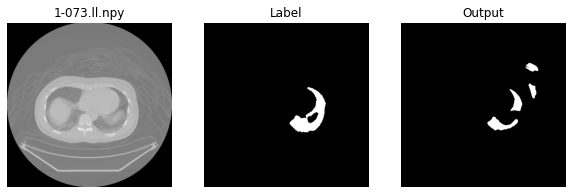

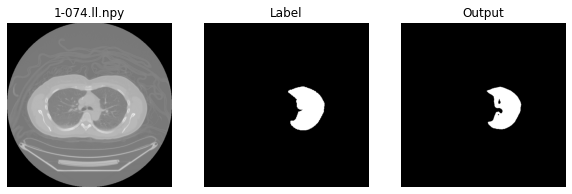

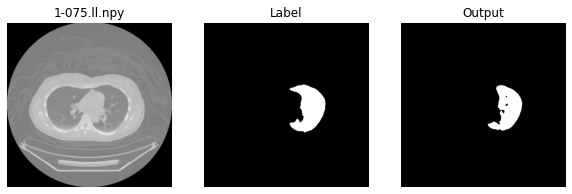

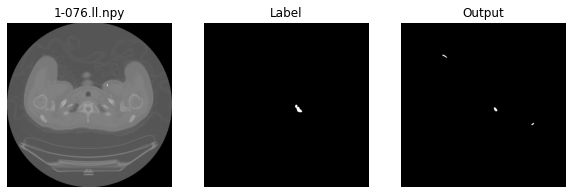

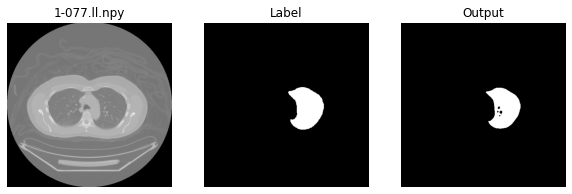

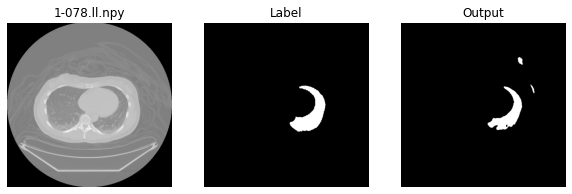

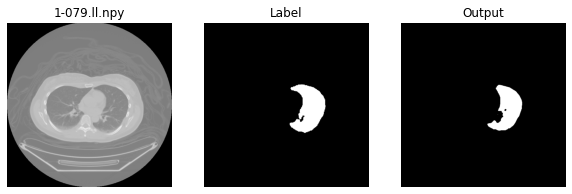

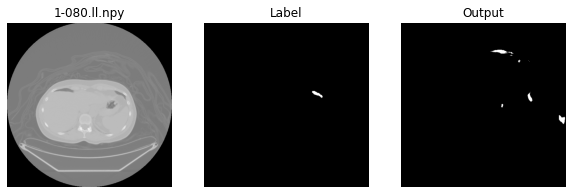

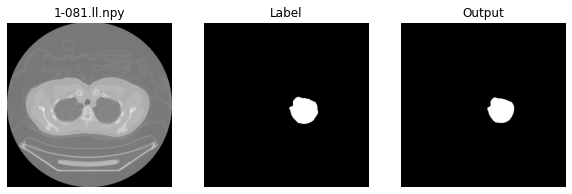

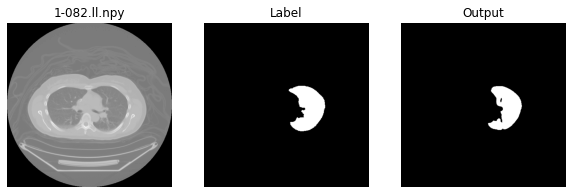

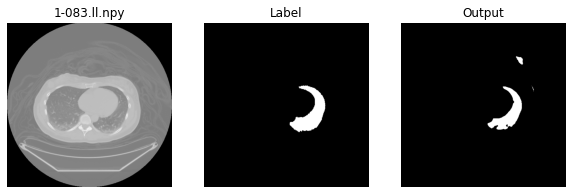

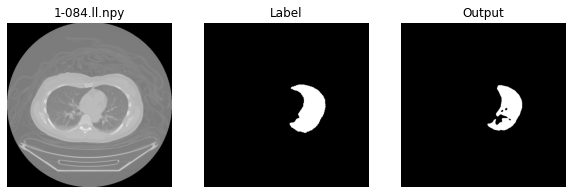

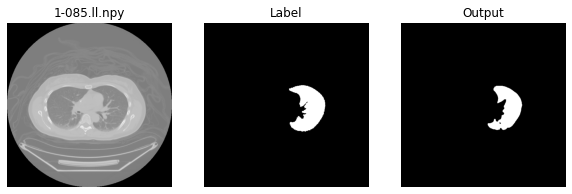

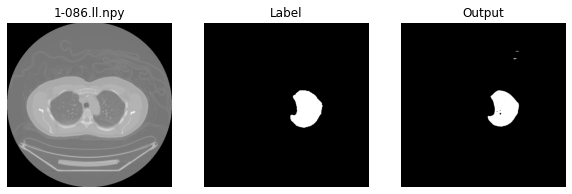

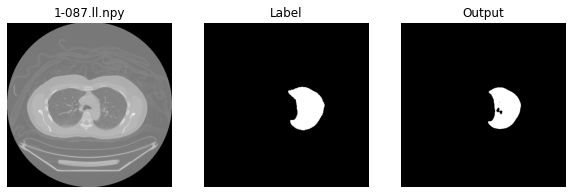

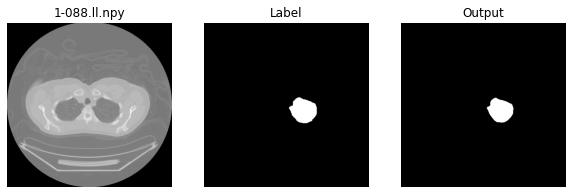

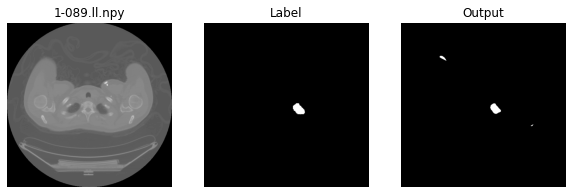

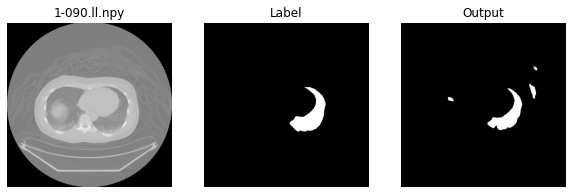

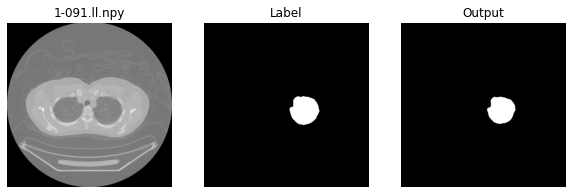

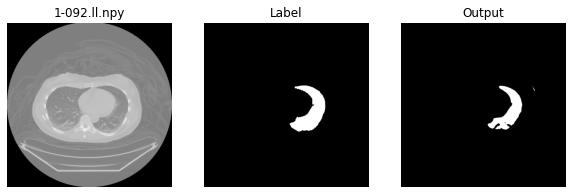

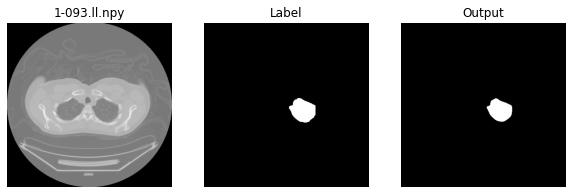

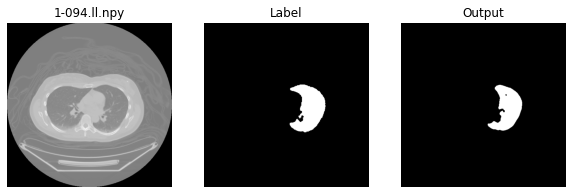

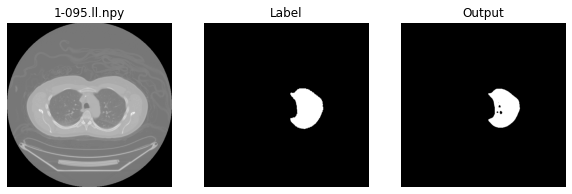

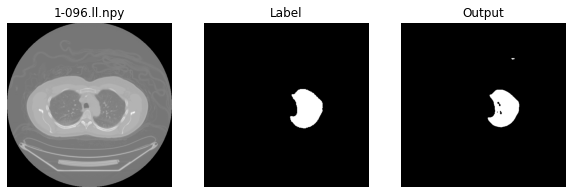

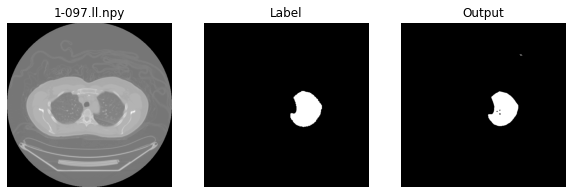

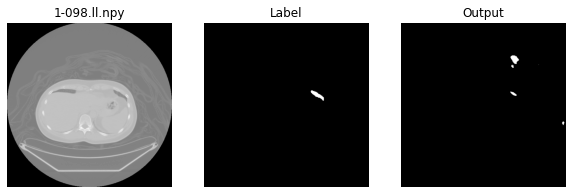

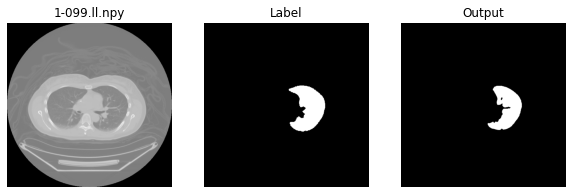

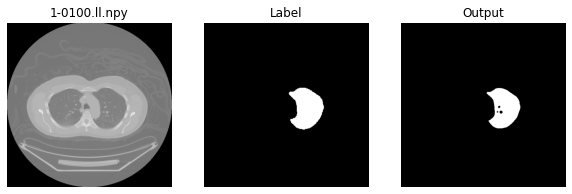

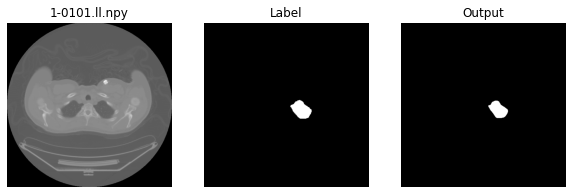

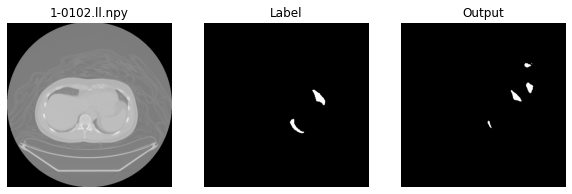

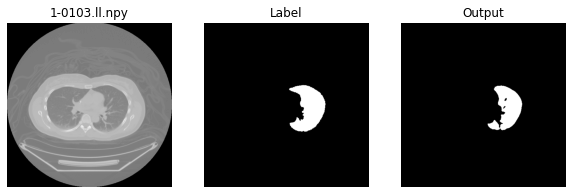

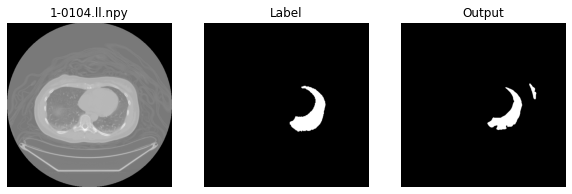

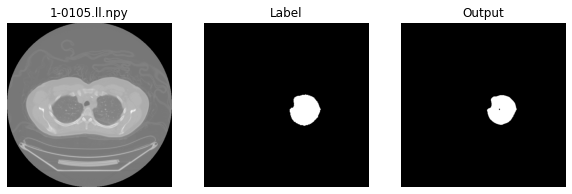

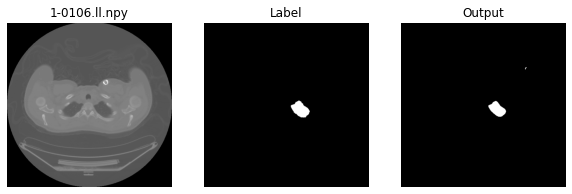

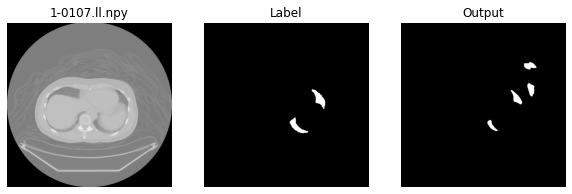

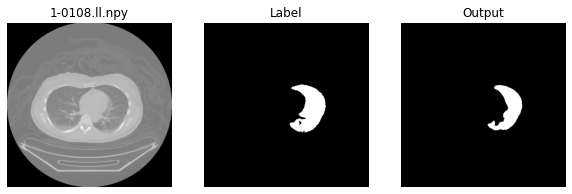

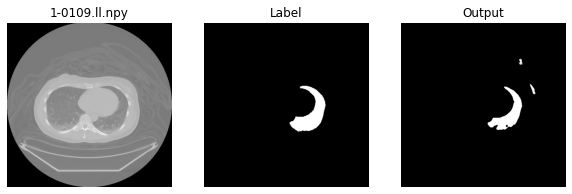

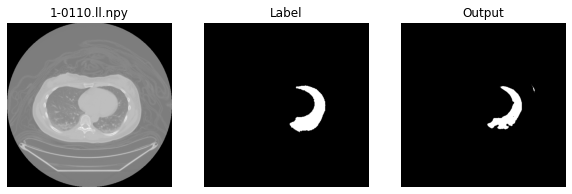

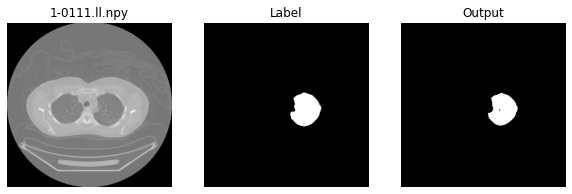

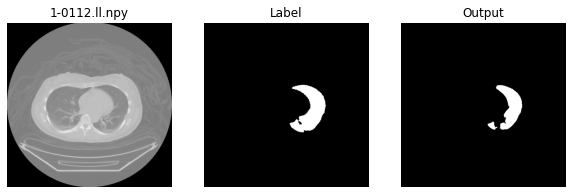

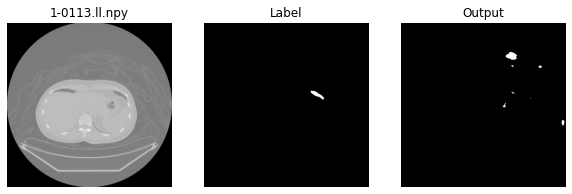

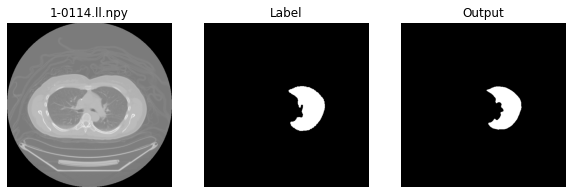

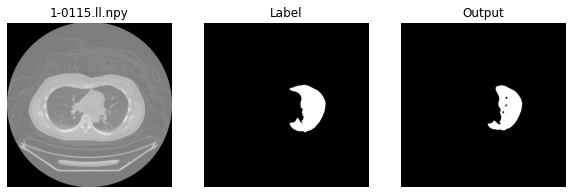

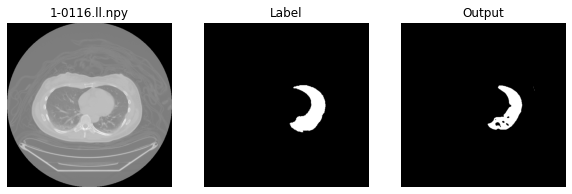

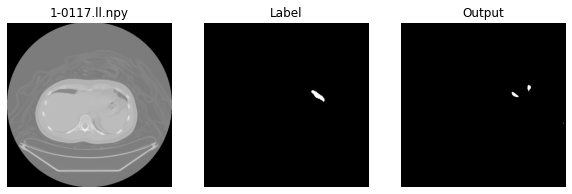

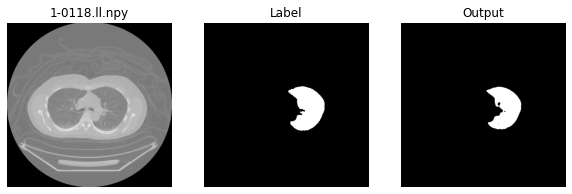

In [ ]:
i=0
with torch.no_grad():
  for batch, data in enumerate(loader_test,1): # 1은 뭐니 > index start point  
          inputs = data['input'].to(device)
          label = data['label'].to(device)
          # 배치 크기 × 채널 × 높이(height) × 너비(widht)
          prediction = net(inputs)
          prediction = prediction.cpu().numpy()
          label = label.cpu().numpy()
          inputs=inputs.cpu().numpy()
          pred=prediction
          pred2 = (pred > 0.7)

          fig = plt.figure(figsize=(10,15))
          ax1 = fig.add_subplot(1, 3, 1)
          ax1.imshow(inputs.reshape(512,512), cmap=plt.cm.gray)
          ax1.set_title('1-0{}.ll.npy'.format(62+i))
          i+=1
          ax1.axis("off")
          ax2 = fig.add_subplot(1, 3, 2)
          ax2.imshow(label.reshape(512,512), cmap=plt.cm.gray)
          ax2.set_title('Label')
          ax2.axis("off")
          ax3 = fig.add_subplot(1, 3, 3)
          ax3.imshow(pred2.reshape(512,512), cmap=plt.cm.gray)
          ax3.set_title('Output')
          ax3.axis("off")
          plt.show()


In [ ]:
with torch.no_grad():
    net.eval()
    total_loss = 0
    preds = []
    preds_thres = []
    labels = []
    real_cost=0
    real_dice=0

    for epoch in range(10):
      avg_cost=0
      avg_dice=0
      total_batch=len(loader_test)
      for batch, data in enumerate(loader_test,1):
          # forward
          label = data['label'].to(device)   # 데이터 device로 올리기     
          inputs = data['input'].to(device)
          # 배치 크기 × 채널 × 높이(height) × 너비(widht)
          prediction = net(inputs)
          
          loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
          pred = prediction
          pred2 = (pred > 0.7)
          
          prediction = prediction.cpu().numpy()
          pred2 = pred2.cpu().numpy()
          label = label.cpu().numpy()
          
          total_loss += loss.item()

          dice_coefficient = mean_dice_coef(label,prediction)

          avg_cost+=loss/total_batch
          avg_dice+=dice_coefficient/total_batch
      real_cost+=avg_cost
      real_dice+=avg_dice
    print('cost={:.9f}, dice_coefficient={:.9f}'.format(real_cost/10, real_dice/10))




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 512, 512])) that is different to the input size (torch.Size([3, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


cost=0.021182453, dice_coefficient=0.571868860


#5. Train2

###1. Unet

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets
 
class sub_UNet(nn.Module):
    def __init__(self):
        super(sub_UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

 

###2. train

In [ ]:
# 네트워크 불러오기
net = sub_UNet().to(device) # device : cpu or gpu

# loss 정의
fn_loss = nn.MSELoss().to(device)

# Optimizer 정의
optim = torch.optim.Adam(net.parameters(), lr = lr ) 

# 기타 variables 설정
num_train = len(dataset_train)

num_train_for_epoch = np.ceil(num_train/batch_size) # np.ceil : 소수점 반올림

# 네트워크 학습시키기
start_epoch = 0

for epoch in range(start_epoch+1,num_epoch +1):
    net.train()
    avg_cost=0
    total_batch=len(loader_train)
    for batch, data in enumerate(loader_train,1):
        # forward
        label = data['label'].to(device)   # 데이터 device로 올리기     
        inputs = data['input'].to(device)
        # 배치 크기 × 채널 × 높이(height) × 너비(widht)
        output = net(inputs) 

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update
        avg_cost+=loss/total_batch
    print('Epoch:', '%04d' %(epoch), 'cost=', '{:.9f}'.format(avg_cost))

Epoch: 0001 cost= 0.049514446
Epoch: 0002 cost= 0.005239286
Epoch: 0003 cost= 0.002745956
Epoch: 0004 cost= 0.001500660
Epoch: 0005 cost= 0.001059589
Epoch: 0006 cost= 0.000908072
Epoch: 0007 cost= 0.000948968
Epoch: 0008 cost= 0.000884429
Epoch: 0009 cost= 0.000994809
Epoch: 0010 cost= 0.000916926


###3. result

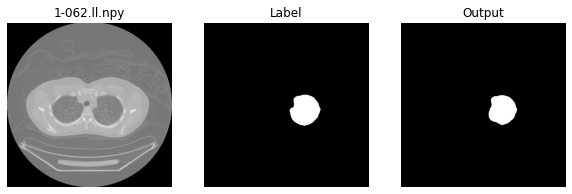

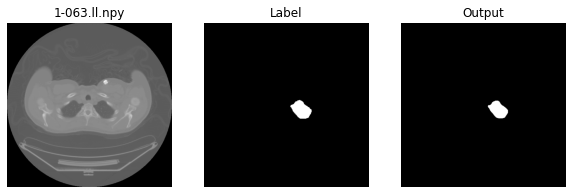

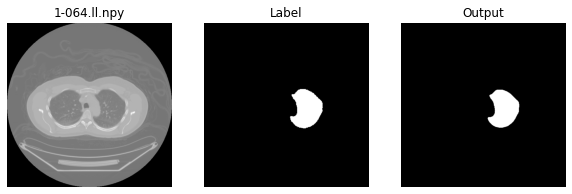

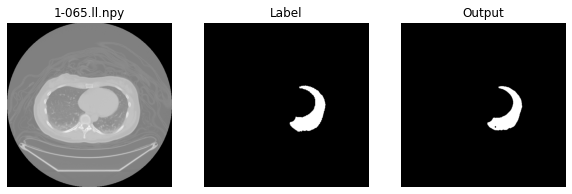

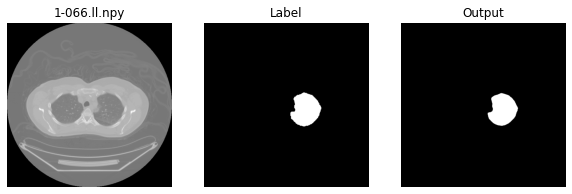

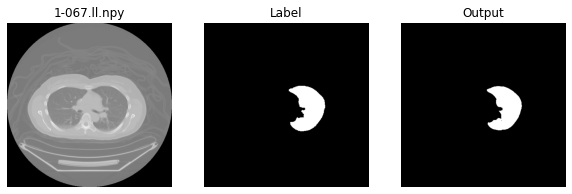

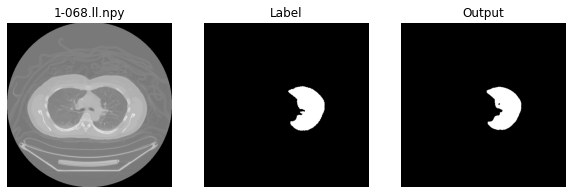

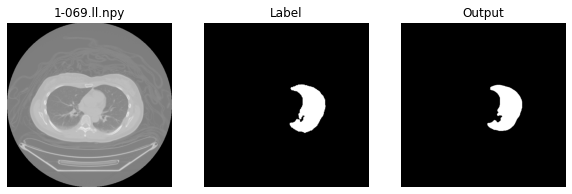

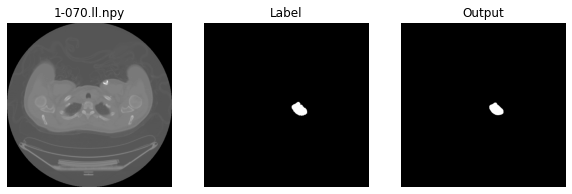

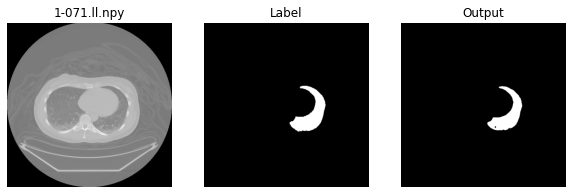

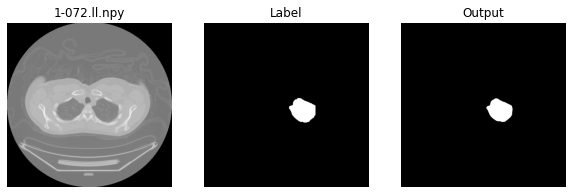

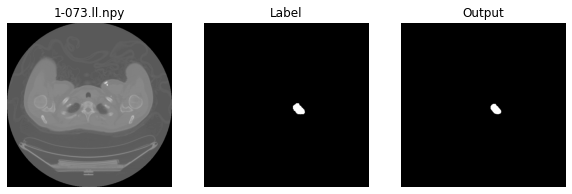

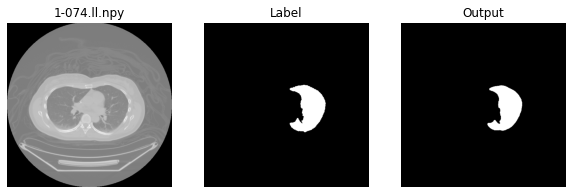

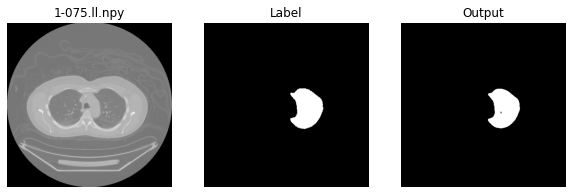

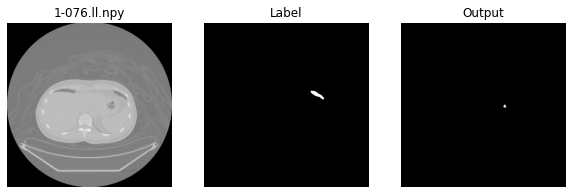

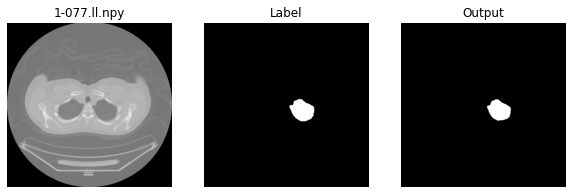

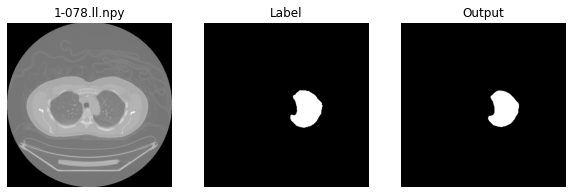

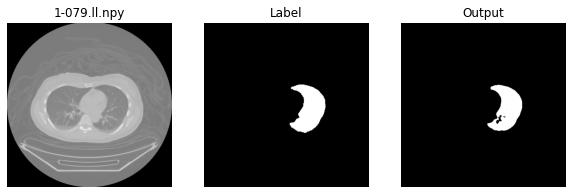

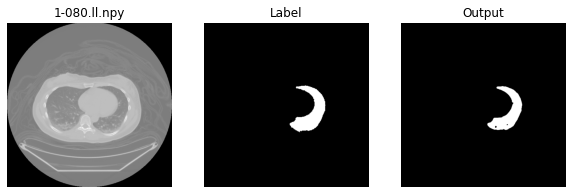

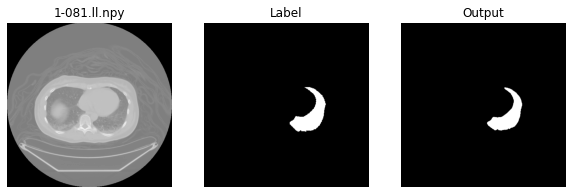

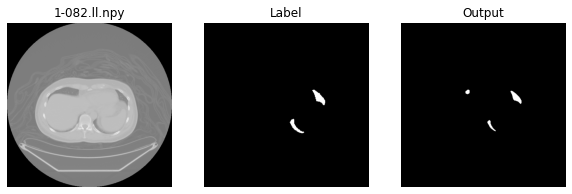

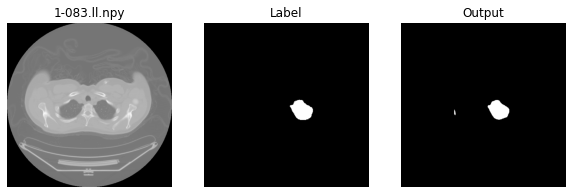

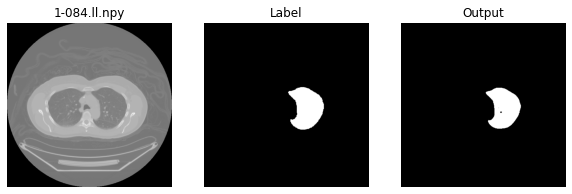

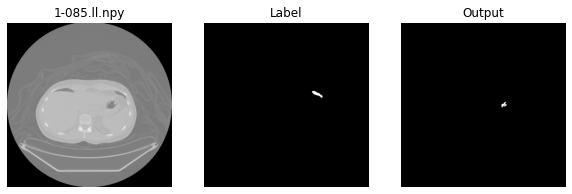

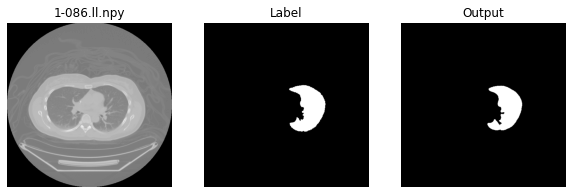

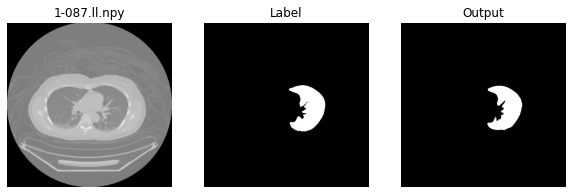

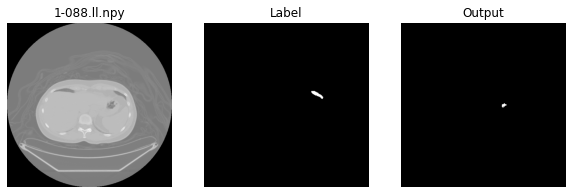

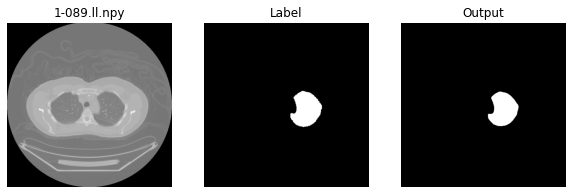

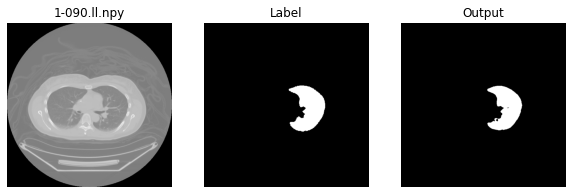

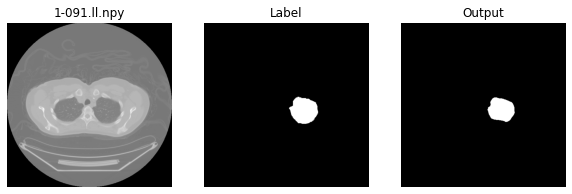

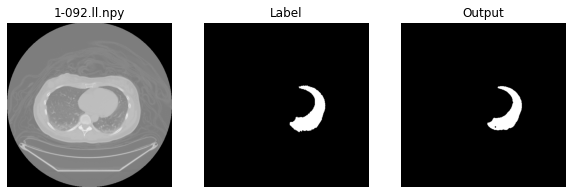

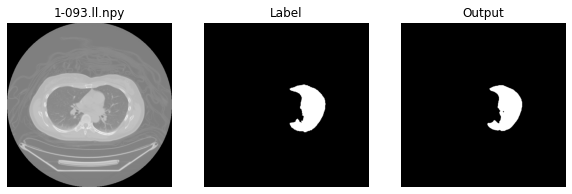

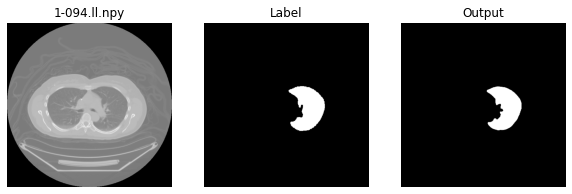

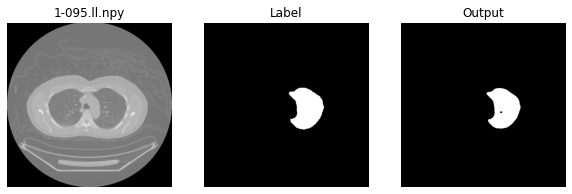

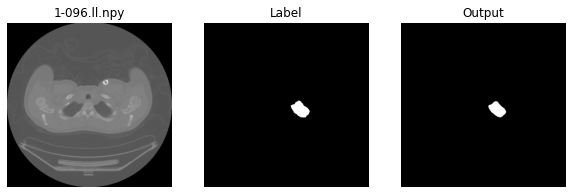

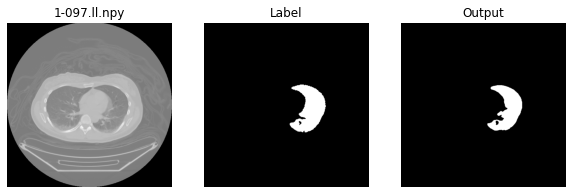

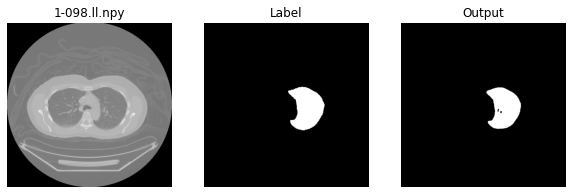

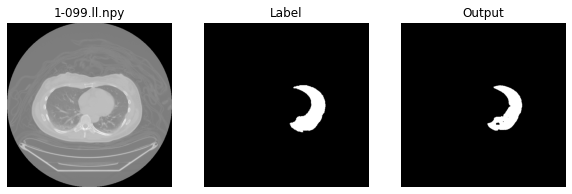

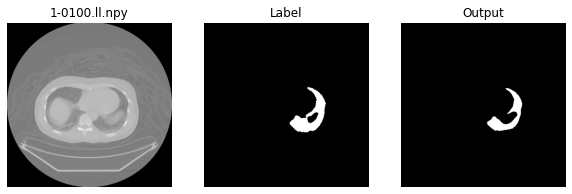

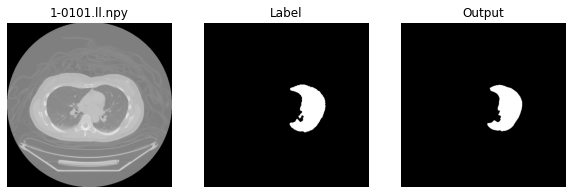

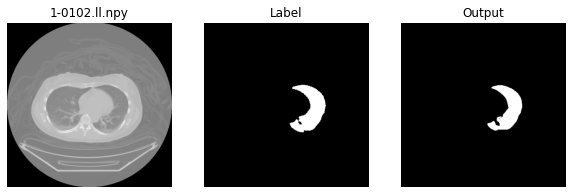

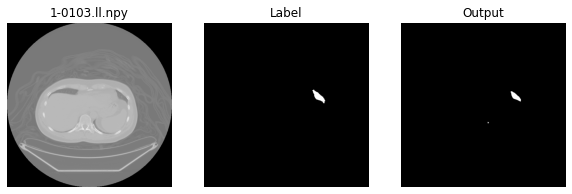

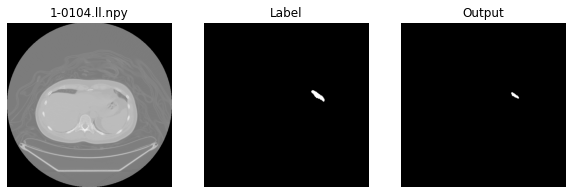

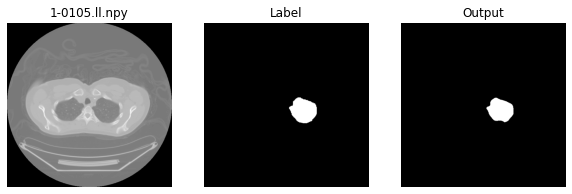

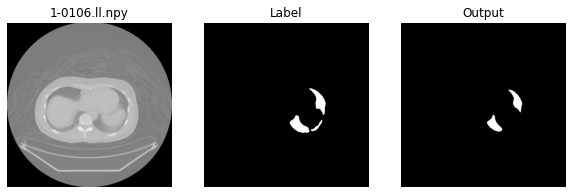

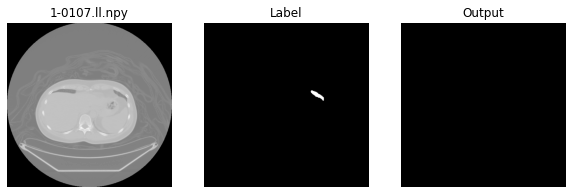

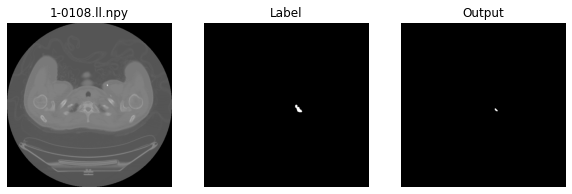

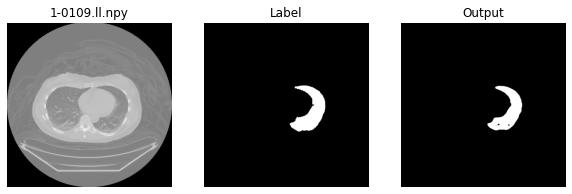

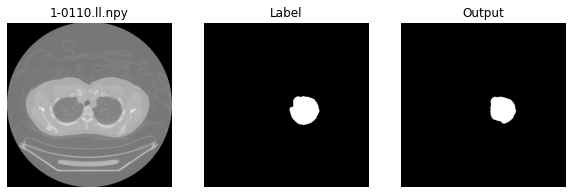

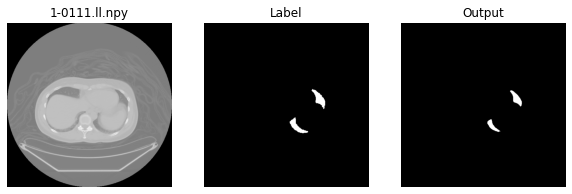

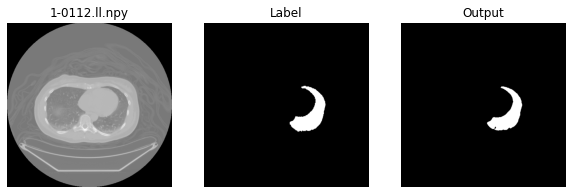

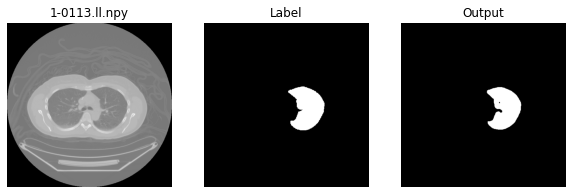

In [ ]:
i=0
with torch.no_grad():
  for batch, data in enumerate(loader_test,1): 
          inputs = data['input'].to(device)
          label = data['label'].to(device)
          # 배치 크기 × 채널 × 높이(height) × 너비(widht)
          prediction = net(inputs)
          prediction = prediction.cpu().numpy()
          label = label.cpu().numpy()
          inputs=inputs.cpu().numpy()
          pred=prediction
          pred2 = (pred > 0.7)

          fig = plt.figure(figsize=(10,15))
          ax1 = fig.add_subplot(1, 3, 1)
          ax1.imshow(inputs.reshape(512,512), cmap=plt.cm.gray)
          ax1.set_title('1-0{}.ll.npy'.format(62+i))
          i+=1
          ax1.axis("  off")
          ax2 = fig.add_subplot(1, 3, 2)
          ax2.imshow(label.reshape(512,512), cmap=plt.cm.gray)
          ax2.set_title('Label')
          ax2.axis("off")
          ax3 = fig.add_subplot(1, 3, 3)
          ax3.imshow(pred2.reshape(512,512), cmap=plt.cm.gray)
          ax3.set_title('Output')
          ax3.axis("off")
          plt.show()


In [ ]:
with torch.no_grad(): 
    total_loss = 0
    preds = []
    preds_thres = []
    labels = []
    real_cost=0
    real_dice=0

    for epoch in range(10):
      avg_cost=0
      avg_dice=0
      total_batch=len(loader_test)
      for batch, data in enumerate(loader_test,1):
          # forward
          label = data['label'].to(device)   # 데이터 device로 올리기     
          inputs = data['input'].to(device)
          # 배치 크기 × 채널 × 높이(height) × 너비(widht)
          prediction = net(inputs)
          
          loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
          pred = prediction
          pred2 = (pred > 0.7)
          
          prediction = prediction.cpu().numpy()
          pred2 = pred2.cpu().numpy()
          label = label.cpu().numpy()
          
          total_loss += loss.item()

          dice_coefficient = mean_dice_coef(label,prediction)

          avg_cost+=loss/total_batch
          avg_dice+=dice_coefficient/total_batch
      #print('Epoch:', '%04d' %(epoch+1), 'cost={:.9f}, dice_coefficient={:.9f}'.format(avg_cost, avg_dice))
      real_cost+=avg_cost
      real_dice+=avg_dice
    print('cost={:.9f}, dice_coefficient={:.9f}'.format(real_cost/10, real_dice/10))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 512, 512])) that is different to the input size (torch.Size([3, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


cost=0.027857849, dice_coefficient=0.796813096


- train2 모델의 성능이 더 좋았다.
- 에폭 수를 늘렸을 때 오히려 dice coefficient값이 더 좋지 않게 나왔다
- label 크기가 작은 경우일 수록 정확도가 떨어지는 모습을 볼 수 있었다



- 직접 모델을 돌려 결과를 확인할 수 있는 좋은 경험이었다.
- 더 정확도가 높은 모델을 만들어 보고 싶다
- BCELoss와 같은 다른 손실함수를 사용해서 비교해보고 싶다.